# Прогнозирование загруженности автотерминала

In [54]:
# Импортируем необходимые библиотеки для работы с данными
import pandas as pd
import numpy as np

# Для визуализации данных
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Избавимся от предупреждений
import warnings
warnings.filterwarnings("ignore")

## 1. Сбор данных и подготовка признаков

In [55]:
culture = pd.read_csv('data/culture.csv') # вид зерна
quotas1 = pd.read_csv('data/quotas1.csv') # квоты (необходимо прибавить 1 день к каждой дате)
trader = pd.read_csv('data/trader.csv') # экспортер
autos1 = pd.read_csv('data/autos_part_11.csv')
autos2 = pd.read_csv('data/autos_part_12.csv') # информация по машинам

#### 1.1. Информация по квотам

In [56]:
display(culture.head())
display(quotas1.head())
display(trader.head())

,id,culture
0,2,5-класс
1,3,Ячмень
2,4,4-класс
3,5,3-класс
4,6,Рис


,date,trader_id,culture_id,confines_count
0,1/6/2022,8,9,120
1,1/6/2022,13,9,50
2,1/6/2022,98,9,100
3,1/6/2022,120,9,40
4,2/6/2022,8,9,120


,id,firm
0,0,"Эксим, ООО"
1,1,"АО ""КСК"""
2,2,"Торговый дом Астон, ООО"
3,7,"МЗК, ООО"
4,8,"Каргилл, ООО"


In [57]:
# Объединение датафреймов по общим столбцам
data = quotas1.merge(
    culture,
    left_on='culture_id',
    right_on='id',
    how='left'
).merge(
    trader,
    left_on='trader_id',
    right_on='id',
    how='left'
)
data.head()

,date,trader_id,culture_id,confines_count,id_x,culture,id_y,firm
0,1/6/2022,8,9,120,9,Пшеница,8,"Каргилл, ООО"
1,1/6/2022,13,9,50,9,Пшеница,13,"Компания Луис Дрейфус Восток, ООО"
2,1/6/2022,98,9,100,9,Пшеница,98,"Торговый дом Риф, ООО"
3,1/6/2022,120,9,40,9,Пшеница,120,"Торговый дом Степь, АХ"
4,2/6/2022,8,9,120,9,Пшеница,8,"Каргилл, ООО"


Даты необходимо предварительно подогнать на 1 день вперед (по рекомендации работодателя).

In [58]:
data = data.drop(columns=['id_x', 'id_y'], axis=1) # удаление лишних столбцов
data['date'] = pd.to_datetime(data['date'], dayfirst=True) # преобразование даты в формат datetime
data['date'] = data['date'] + pd.Timedelta(days=1) # добавляем день вперед
data = data.sort_values(by=['date', 'firm']).reset_index(drop=True) # сортировка данных по дате и фирме
data = data[data['date'] <= '2025-06-25'] # подгоним даты под один размер

In [59]:
# Взглянем на пропуски и на дубликаты
display(data.isna().sum())

print('Размер данных: {}'.format(data.shape[0]))
print('Кол-во дубликатов: {}'.format(data[data.duplicated()].shape[0]))
# Избавимся от них
data = data.drop_duplicates()
print('Кол-во строк после удаления дубликатов: {}'.format(data.shape[0]))

date              0
trader_id         0
culture_id        0
confines_count    0
culture           0
firm              0
dtype: int64

Размер данных: 9853
Кол-во дубликатов: 696
Кол-во строк после удаления дубликатов: 9157


Замечательно, пропусков нет

Стоит отметить, что могут быть пропущены даты, так как зерновой терминал не всегда может принимать авто, соответственно не всегда выдает квоты. Найдем их и заполним нулями.

In [60]:
# Выделим признак ожидаемого количества авто
expected_trucks = data.groupby('date')['confines_count'].sum().reset_index()
print(f'Количество имеющихся дат: {expected_trucks.shape[0]}')

# Зададим необходимый диапазон дат
min_date = expected_trucks['date'].min()
max_date = expected_trucks['date'].max()
full_dates = pd.date_range(min_date, max_date, freq='d')

# Найдем пропущенные даты
existing_dates = expected_trucks['date'].unique()
missing_dates = [date for date in full_dates if date not in existing_dates]
print(f'Кол-во пропущенных дат: {len(missing_dates)}')

# Создадим DataFrame с пропущенными значениями и объединим его с нашим
missing_dates = pd.DataFrame({
    'date': missing_dates,
    'confines_count': 0
})

expected_trucks = pd.concat([expected_trucks, missing_dates]).sort_values(by='date').reset_index(drop=True)
display(expected_trucks)

Количество имеющихся дат: 1055
Кол-во пропущенных дат: 65


,date,confines_count
0,2022-06-02,310
1,2022-06-03,360
2,2022-06-04,365
3,2022-06-05,310
4,2022-06-06,350
...,...,...
1115,2025-06-21,406
1116,2025-06-22,385
1117,2025-06-23,385
1118,2025-06-24,191


#### 1.2. Датасет по машинам от экспедиторской компании

In [61]:
# Объединим в один датафрейм
autos = pd.concat([autos1, autos2], ignore_index=True)
autos.head()

,date(bb.windows),num_auto,culture,firm,mas,date_cre,"CONCAT(nztmodule3.objects.date_from_podskok, "" "", nztmodule3.objects.time_from_podskok)","CONCAT(nztmodule3.objects.date_to_nzt, "" "", nztmodule3.objects.time_to_nzt)","CONCAT(nztmodule3.objects.date_from_nzt, "" "", nztmodule3.objects.time_from_nzt)"
0,26/6/2025,A338HM193,9,502,32.88,27/6/2025 00:24:21,2025-06-27 01:19:48,2025-06-27 02:05:47,2025-06-27 02:44:18
1,27/6/2025,M567TC126,9,502,32.30,27/6/2025 00:21:18,2025-06-27 01:25:16,2025-06-27 02:00:26,2025-06-27 02:37:58
2,26/6/2025,K826OM126,9,502,29.52,27/6/2025 00:07:20,2025-06-27 01:18:24,2025-06-27 01:55:59,2025-06-27 02:58:43
3,26/6/2025,P857MY761,9,502,30.04,26/6/2025 22:26:10,2025-06-27 00:14:45,2025-06-27 00:48:18,2025-06-27 01:23:06
4,26/6/2025,M458TP193,9,502,32.82,26/6/2025 22:21:25,2025-06-27 00:13:57,2025-06-27 00:52:12,2025-06-27 02:52:27


In [62]:
# Переименуем столбцы
autos = autos.rename(columns={
    'CONCAT(nztmodule3.objects.date_from_podskok, " ", nztmodule3.objects.time_from_podskok)': 'leaving_terminal',
    'CONCAT(nztmodule3.objects.date_to_nzt, " ", nztmodule3.objects.time_to_nzt)': 'entry_ksk',
    'CONCAT(nztmodule3.objects.date_from_nzt, " ", nztmodule3.objects.time_from_nzt)': 'leaving_ksk',
    'date(bb.windows)': 'date'
})

# Добавим названия фирм и тип зерна для наглядности
autos = autos.merge(
    culture,
    left_on='culture',
    right_on='id',
    how='left'
).merge(
    trader,
    left_on='firm',
    right_on='id',
    how='left'
)
autos = autos.drop(columns=['id_x', 'id_y']) # удалим лишние столбцы

In [63]:
# Меняем формат даты на datetime
autos['date'] = pd.to_datetime(autos['date'])
autos['date_cre'] = pd.to_datetime(autos['date_cre'])
autos['leaving_terminal'] = pd.to_datetime(autos['leaving_terminal'])
autos['entry_ksk'] = pd.to_datetime(autos['entry_ksk'])
autos['leaving_ksk'] = pd.to_datetime(autos['leaving_ksk'])

In [64]:
# Подгоним данные по дате
autos = autos[(autos['date'] >= '2022-06-02') & (autos['date'] <= '2025-06-25')]

# Посмотрим наличие дубликатов
print('Размер данных: {}'.format(autos.shape[0]))
print('Кол-во дубликатов: {}'.format(autos[autos.duplicated()].shape[0]))
# Избавимся от них
autos = autos.drop_duplicates()
print('Кол-во строк после удаления дубликатов: {}'.format(autos.shape[0]))

Размер данных: 533251
Кол-во дубликатов: 86118
Кол-во строк после удаления дубликатов: 447133


#### 1.3. Датасет от зернового терминала

In [65]:
operations_ksk = pd.read_csv('data/operations_ksk.csv') # данные с зернового терминала

display(operations_ksk.head())
display(operations_ksk.info())

,Unnamed: 0,Дата,Квартал,Смена,"ТХ смена, тн","ТХ сутки, тн","АМ смена, шт","АМ сутки, 8","АМ смена, тн","АМ сутки, тн","ЖД смена, шт","ЖД сутки, 8","ЖД смена, тн","ЖД сутки, тн","Приход смена,тн","Приход сутки,тн"
0,0,2021-01-01 08:00:00,1.0,2.0,1500,1500,0,0,0.0,0,80.0,141,5759.0,10130,5759.0,10130
1,1,2021-01-01 20:00:00,1.0,1.0,0,NaN,0,NaN,0.0,NaN,61.0,NaN,4371.0,NaN,4371.0,0
2,2,2021-01-02 08:00:00,1.0,3.0,0,8781,0,0,0.0,0,65.0,137,4558.0,9658,4558.0,9658
3,3,2021-01-02 20:00:00,1.0,2.0,8781,NaN,0,NaN,0.0,NaN,72.0,NaN,5100.0,NaN,5100.0,0
4,4,2021-01-03 08:00:00,1.0,4.0,16547,26719,10,74,274.0,1940,85.0,170,6058.0,12130,6332.0,14070


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        3346 non-null   int64  
 1   Дата              3346 non-null   object 
 2   Квартал           3346 non-null   float64
 3   Смена             3346 non-null   float64
 4   ТХ смена, тн      3346 non-null   object 
 5   ТХ сутки, тн      1673 non-null   object 
 6   АМ смена, шт      3346 non-null   object 
 7   АМ сутки, 8       1673 non-null   object 
 8   АМ смена, тн      3346 non-null   float64
 9   АМ сутки, тн      1673 non-null   object 
 10  ЖД смена, шт      3346 non-null   float64
 11  ЖД сутки, 8       1673 non-null   object 
 12  ЖД смена, тн      3346 non-null   float64
 13  ЖД сутки, тн      1673 non-null   object 
 14  Приход смена,тн   3346 non-null   float64
 15  Приход  сутки,тн  3012 non-null   object 
dtypes: float64(6), int64(1), object(9)
memory 

None

Выделим отсюда необходимые признаки:

`ТХ сутки, тн` - количество погруженного за сутки зерна на судно (в тоннах);

`АМ сутки, 8` - количество авто, заехавших за сутки;

`АМ сутки, тн` - количество прибывшего груза на авто (в тоннах);

`ЖД сутки, 8` - количество прибывших вагонов за сутки;

`ЖД сутки, тн` - количество прибывшего груза на жд (в тоннах).

In [66]:
operations_ksk = operations_ksk.drop('Unnamed: 0', axis=1) # лишний столбец
operations_ksk['Дата'] = pd.to_datetime(operations_ksk['Дата']) # в формат datetime
operations_ksk['date'] = pd.to_datetime(operations_ksk['Дата'].dt.date) # добавим столбец только с датой
operations_ksk = operations_ksk[
    (operations_ksk['date'] >= '2022-06-02') &
    (operations_ksk['date'] <= '2025-06-25')
] # подгоним под единый временной промежуток
operations_ksk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2240 entries, 1034 to 3273
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Дата              2240 non-null   datetime64[ns]
 1   Квартал           2240 non-null   float64       
 2   Смена             2240 non-null   float64       
 3   ТХ смена, тн      2240 non-null   object        
 4   ТХ сутки, тн      1120 non-null   object        
 5   АМ смена, шт      2240 non-null   object        
 6   АМ сутки, 8       1120 non-null   object        
 7   АМ смена, тн      2240 non-null   float64       
 8   АМ сутки, тн      1120 non-null   object        
 9   ЖД смена, шт      2240 non-null   float64       
 10  ЖД сутки, 8       1120 non-null   object        
 11  ЖД смена, тн      2240 non-null   float64       
 12  ЖД сутки, тн      1120 non-null   object        
 13  Приход смена,тн   2240 non-null   float64       
 14  Приход  сутки,тн  1907 non

Пропуски в этих данных следует заполнить нулями для дальнейшего преобразования

In [67]:
# Заполним все пропуски нулями
operations_ksk = operations_ksk.fillna(0)

# Преобразуем необходимые столбцы во float
operations_ksk['АМ сутки, 8'] = operations_ksk['АМ сутки, 8'].astype(float)
operations_ksk['АМ сутки, тн'] = operations_ksk['АМ сутки, тн'].astype(float)
operations_ksk['ЖД сутки, 8'] = operations_ksk['ЖД сутки, 8'].astype(float)
operations_ksk['ЖД сутки, тн'] = operations_ksk['ЖД сутки, тн'].astype(float)
operations_ksk['ТХ сутки, тн'] = operations_ksk['ТХ сутки, тн'].astype(float)

# Данные по ежедневным операциям на зерновом терминале
daily_operations = operations_ksk.groupby('date')[['АМ сутки, 8', 'АМ сутки, тн', 'ЖД сутки, 8', 'ЖД сутки, тн', 'ТХ сутки, тн']].sum().reset_index()
daily_operations.head()

,date,"АМ сутки, 8","АМ сутки, тн","ЖД сутки, 8","ЖД сутки, тн","ТХ сутки, тн"
0,2022-06-02,133.0,3624.0,33.0,2406.0,0.0
1,2022-06-03,226.0,6253.0,18.0,1342.0,0.0
2,2022-06-04,194.0,5405.0,0.0,0.0,0.0
3,2022-06-05,115.0,3188.0,0.0,0.0,0.0
4,2022-06-06,194.0,5400.0,15.0,1129.0,0.0


Создадим целевой признак накопления авто на стоянке, для этого найдем количество машин на каждый час и агрегируем часы с пиковым значениям по дням.

In [68]:
# Посмотрим сколько авто находилось на автотерминале по часам
start_time = autos['date_cre'].min().floor('h') # округление вниз до часа
end_time = autos['leaving_terminal'].max().ceil('h') # округление вверх до часа

# Создадим часовые интервалы
hourly_intervals = pd.date_range(
    start=start_time,
    end=end_time,
    freq='h'
)

# Создаем список для результатов
counts = []
# Для ускорения преобразуем времена в массивы numpy
entry_times = autos['date_cre'].values
exit_times = autos['leaving_terminal'].values

for hour_start in hourly_intervals:
    hour_end = hour_start + pd.Timedelta(hours=1)
    
    in_hour = (
        (entry_times < hour_end) &
        (exit_times > hour_start)
    )
    
    counts.append(in_hour.sum())
    
# Создаем DataFrame с результатами
hourly_terminal = pd.DataFrame({
    'hour': hourly_intervals,
    'num_autos': counts
})

In [69]:
hourly_terminal.sort_values(by='num_autos')

,hour,num_autos
26909,2025-06-27 04:00:00,0
12899,2023-11-21 10:00:00,0
12900,2023-11-21 11:00:00,0
12901,2023-11-21 12:00:00,0
12902,2023-11-21 13:00:00,0
...,...,...
16475,2024-04-18 10:00:00,547
1640,2022-08-09 07:00:00,549
1643,2022-08-09 10:00:00,558
1642,2022-08-09 09:00:00,568


Преобразуем почасовые данные в ежедневные, в качестве значения выделив пиковый час. Это и будет нашей целевой переменной.

In [70]:
daily_autoterminal = hourly_terminal.copy()
daily_autoterminal['date'] = pd.to_datetime(daily_autoterminal['hour'].dt.date)
daily_autoterminal = daily_autoterminal.groupby('date')['num_autos'].max().reset_index() # ежедневное кол-во авто
daily_autoterminal = daily_autoterminal[(daily_autoterminal['date'] >= '2022-06-02') & (daily_autoterminal['date'] <= '2025-06-25')] # под единый диапазон

#### 1.4. Информация по отсрочкам принятия авто на зерновом терминале

In [71]:
delay = pd.read_excel('data/delay.xlsx')
delay = delay[
    (delay['Дата'] >= '2022-06-02') &
    (delay['Дата'] <= '2025-06-25')
] # единый диапазон дат

# Удалим столбец с часами
delay = delay.drop('Часы', axis=1)

# Переименуем столбцы
delay.rename(columns={
    'Дата': 'date',
    'Сутки': 'part_day'
}, inplace=True)

display(delay.head())
display(delay.info())

,date,part_day
152,2022-06-02,0.0
153,2022-06-03,0.0
154,2022-06-04,0.0
155,2022-06-05,0.0
156,2022-06-06,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 1120 entries, 152 to 1271
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1120 non-null   datetime64[ns]
 1   part_day  1120 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.2 KB


None

Чаще всего зерновой терминал приостанавливает приемку авто в зимние месяца, что логично, так как погода в Новороссийске как раз ведет себя хуже всего в это время года.

#### 1.5. Информация по судам

In [72]:
vessels = pd.read_excel('data/vessels.xlsx')
vessels.drop(columns=['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 5'], axis=1, inplace=True)
vessels.head()

,наименование судна,окончание,окончание.1
0,LILA,2022-05-31 15:35:00,2022-06-02 02:30:00
1,MONTARA,2022-06-07 11:50:00,2022-06-10 11:40:00
2,EIDER S,2022-06-10 13:00:00,2022-06-12 17:05:00
3,THE UNITY,2022-06-15 16:15:00,2022-06-19 13:45:00
4,AGERI,2022-06-19 16:30:00,2022-06-21 20:35:00


In [73]:
# Переименуем столбцы
vessels = vessels.rename(columns={
    'окончание': 'start',
    'окончание.1': 'end'
})

Аналогично машинам, сделаем накопление судов по дням.

In [74]:
# Создадим дневные интервалы
daily_intervals = pd.date_range(
    start='2022-06-02',
    end='2025-06-25',
    freq='d'
)

# Создаем список для результатов
counts_vessels = []

# Для ускорения преобразуем времена в массивы numpy
entry_times_v = vessels['start'].values
exit_times_v = vessels['end'].values

# Проходим по каждому дневному интервалу и считаем, сколько судов было в этот день
for day_start in daily_intervals:
    day_end = day_start + pd.Timedelta(days=1)
    
    in_day = (
        (entry_times_v < day_end) &
        (exit_times_v > day_start)
    )
    
    counts_vessels.append(in_day.sum())
    
# Создаем DataFrame с результатами
daily_vessels = pd.DataFrame({
    'date': daily_intervals,
    'vessels': counts_vessels
})

#### 1.6. Информация по силосам (хранилищам)

Мне получилось достать информацию по хранилищам за один день, ничего страшного, так как у нас имеется вся необходимая информация по прибывшим и погруженным грузам. Посчитаем остальные дни.

In [75]:
warehouse = pd.read_excel('data/Warehouses 01.04.2025.xls', sheet_name=2)

# Создадим дневные интервалы с 01-04-2025 по 25-06-2025
date_range1 = pd.date_range(
    start='2025-04-01',
    end='2025-06-25',
    freq='d'
)

# Зададим начальное значение
start_point = warehouse['Остаток'].iloc[-1] / 1000 # из кг в тонны

# Посчитаем количество зерна в хранилищах за этот период
period1 = daily_operations[daily_operations['date'] >= '2025-04-01']

# Считаем ежедневное изменение зерна (в килограммах)
daily_movements1 = (
    period1['АМ сутки, тн'] + 
    period1 ['ЖД сутки, тн'] - 
    period1['ТХ сутки, тн'] 
)

# Вычисляем накопленное изменение, сдвигаем на один день назад,
# чтобы значение на 01.04.2025 совпадало с начальным остатком
daily_movements1 = start_point + daily_movements1.cumsum().shift(1, fill_value=0)

# Промежуточный DataFrame
warehouses1 = pd.DataFrame({
    'date': date_range1,
    'warehouse_fullness': daily_movements1
})

# Далее зададим период до известной даты
date_range2 = pd.date_range(
    start='2022-06-02',
    end='2025-03-31',
    freq='d' 
)

# Отбираем операции до 01.04.2025 и отсортируем в обратном порядке
period2 = daily_operations[daily_operations['date'] < '2025-04-01']
period2 = period2.sort_values(by='date', ascending=False).reset_index(drop=True)

# Считаем ежедневные изменения с инвертированными знаками
daily_movements2 = (
    - period2['АМ сутки, тн']
    - period2 ['ЖД сутки, тн']
    + period2['ТХ сутки, тн'] 
)

# Считаем кумулятивную сумму без сдвига
daily_movements2 = start_point + daily_movements2.cumsum()[::-1] # обратно в тонны

# Промежуточный DataFrame
warehouses2 = pd.DataFrame({
    'date': date_range2,
    'warehouse_fullness': daily_movements2
})

# Объединим в один датасет
warehouses = pd.concat([warehouses2, warehouses1], ignore_index=True)

#### 1.7. Итоговый датасет

In [76]:
final_data = (
    expected_trucks
    .merge(delay, on='date')               # отсрочки принятия авто
    .merge(daily_vessels, on='date')       # количество судов
    .merge(daily_operations, on='date')    # операции на терминале
    .merge(daily_autoterminal, on='date')  # количество авто в пиковый час (целевой признак)
    .merge(warehouses, on='date')          # количество зерна в хранилищах на начало дня
)

# Переименуем некоторые признаки
final_data = final_data.rename(columns={
    'АМ сутки, 8': 'fact_autos',
    'АМ сутки, тн': 'cargo_autos',
    'ЖД сутки, 8': 'fact_rail',
    'ЖД сутки, тн': 'cargo_rail',
    'ТХ сутки, тн': 'loaded',
    'confines_count': 'expected_autos'
})

final_data.head()

,date,expected_autos,part_day,vessels,fact_autos,cargo_autos,fact_rail,cargo_rail,loaded,num_autos,warehouse_fullness
0,2022-06-02,310,0.0,2,133.0,3624.0,33.0,2406.0,0.0,50,127447.262
1,2022-06-03,360,0.0,1,226.0,6253.0,18.0,1342.0,0.0,36,133477.262
2,2022-06-04,365,0.0,1,194.0,5405.0,0.0,0.0,0.0,26,141072.262
3,2022-06-05,310,0.0,1,115.0,3188.0,0.0,0.0,0.0,21,146477.262
4,2022-06-06,350,0.0,1,194.0,5400.0,15.0,1129.0,0.0,34,149665.262


Выделим больше признаков из дат

In [77]:
final_data['day'] = final_data['date'].dt.day # день
final_data['month'] = final_data['date'].dt.month # месяц
final_data['day_of_week'] = final_data['date'].dt.day_of_week # день недели

##### 1.7.1. Временные лаги

Добавим значения целевой переменной вчерашней и недельной давности.

Также стоит добавить вчерашние значения простоя зернового терминала, так как это может влиять на сегодняшние значения авто из-за переносов въезда на территорию порта.

In [78]:
final_data['num_autos_lag_1'] = final_data['num_autos'].shift(1)
final_data['num_autos_lag_7'] = final_data['num_autos'].shift(7)
final_data['part_day_lag_1'] = final_data['part_day'].shift(1)

# Удалим строки с пропущенными значениями из-за лагов
final_data.dropna(inplace=True)
final_data = final_data.reset_index(drop=True)

Добавим информацию по официальным праздничным и выходным дням в России за 2022-2025.

In [79]:
holidays = pd.read_excel('data/holidays.xlsx') # датасет с праздниками/выходными

final_data['is_holiday'] = final_data['date'].isin(holidays['date']).astype(int) # 1 — если дата в списке праздников, иначе 0

print('Количество пропусков: {}'.format(final_data.isna().sum().sum())) # посмотрим кол-во пропусков
display(final_data.head())
display(final_data.info())

Количество пропусков: 0


,date,expected_autos,part_day,vessels,fact_autos,cargo_autos,fact_rail,cargo_rail,loaded,num_autos,warehouse_fullness,day,month,day_of_week,num_autos_lag_1,num_autos_lag_7,part_day_lag_1,is_holiday
0,2022-06-09,455,0.0,2,359.0,9882.0,28.0,1999.0,5023.0,40,149153.262,9,6,3,42.0,50.0,0.0,0
1,2022-06-10,455,0.0,3,332.0,9172.0,13.0,917.0,23777.0,47,156011.262,10,6,4,40.0,36.0,0.0,0
2,2022-06-11,455,0.0,2,250.0,6882.0,39.0,2874.0,28523.0,55,142323.262,11,6,5,47.0,26.0,0.0,1
3,2022-06-12,400,0.0,2,131.0,3669.0,18.0,1287.0,0.0,31,123556.262,12,6,6,55.0,21.0,0.0,1
4,2022-06-13,400,0.0,1,170.0,4819.0,0.0,0.0,0.0,34,128512.262,13,6,0,31.0,34.0,0.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1113 non-null   datetime64[ns]
 1   expected_autos      1113 non-null   int64         
 2   part_day            1113 non-null   float64       
 3   vessels             1113 non-null   int64         
 4   fact_autos          1113 non-null   float64       
 5   cargo_autos         1113 non-null   float64       
 6   fact_rail           1113 non-null   float64       
 7   cargo_rail          1113 non-null   float64       
 8   loaded              1113 non-null   float64       
 9   num_autos           1113 non-null   int64         
 10  warehouse_fullness  1113 non-null   float64       
 11  day                 1113 non-null   int32         
 12  month               1113 non-null   int32         
 13  day_of_week         1113 non-null   int32       

None

## 2. Разведывательный анализ

Посмотрим, насколько отличается фактическое количество авто от квот

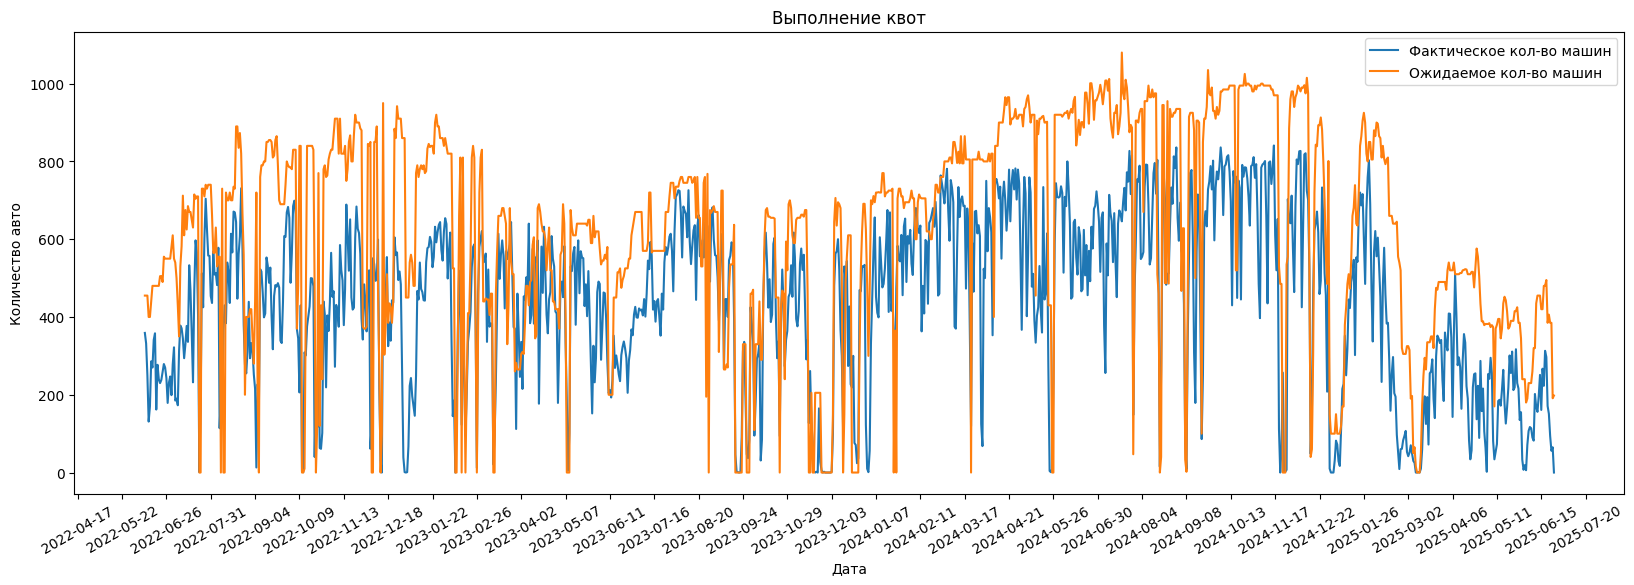

In [80]:
fig = plt.figure(figsize=(20, 6))
ax = plt.gca()

sns.lineplot(final_data, x='date', y='fact_autos', ax=ax, label='Фактическое кол-во машин')
sns.lineplot(final_data, x='date', y='expected_autos', ax=ax, label='Ожидаемое кол-во машин')
ax.set_title('Выполнение квот')
ax.set_xlabel('Дата');
ax.set_ylabel('Количество авто');
ax.xaxis.set_major_locator(mdates.DayLocator(interval=35));
plt.xticks(rotation=30);

Видим, что в основном фактического количества машин всегда меньше ожидаемого, это нормально, так как зерновой терминал всегда запрашивает максимум от своих возможностей. Резкие падения оранжевой линии к нулю указывают на то, что терминал не выдавал квот на эти дни.

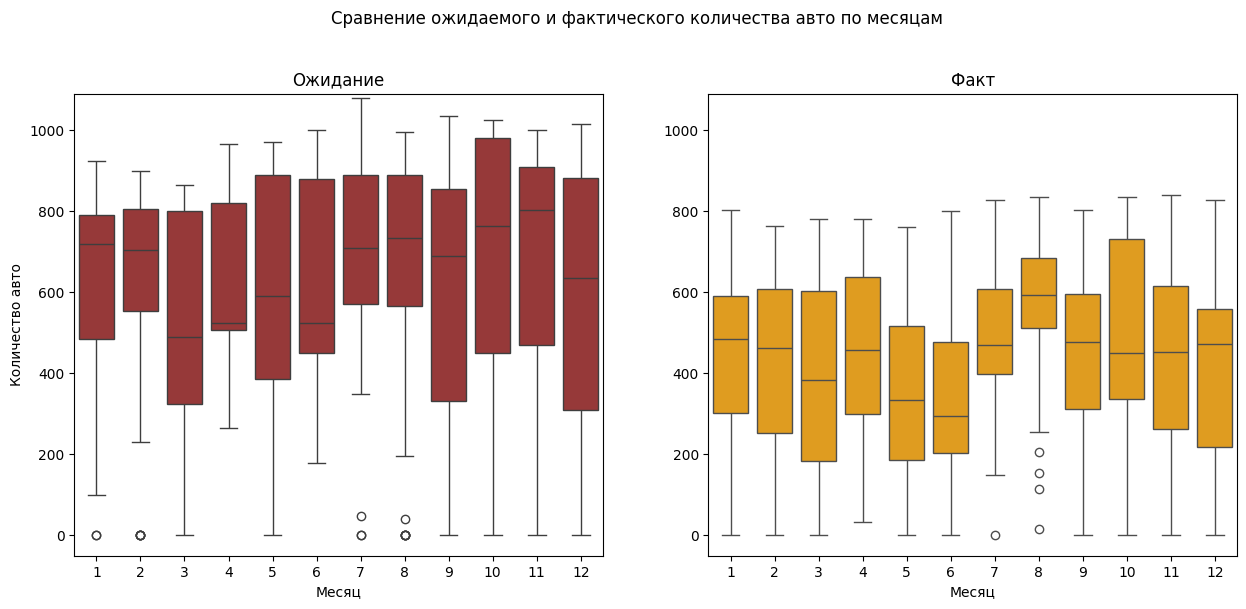

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Сравнение ожидаемого и фактического количества авто по месяцам', y=1.02)

# Для ожидаемых авто
sns.boxplot(final_data, x='month', y='expected_autos', color='brown', ax=axes[0])
axes[0].set_title('Ожидание')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Количество авто')
axes[0].set_ylim(-50, final_data[['expected_autos', 'fact_autos']].max().max() + 10) # под единый масштаб
# Для фактических авто
sns.boxplot(final_data, x='month', y='fact_autos', color='orange', ax=axes[1])
axes[1].set_title('Факт')
axes[1].set_xlabel('Месяц')
axes[1].set_ylabel('')
axes[1].set_ylim(-50, final_data[['expected_autos', 'fact_autos']].max().max() + 10);

В среднем зерновой терминал принимает большее количество машин в теплое время года. 
Также можем лишний раз убедиться в разнице квот от факта.

Построим график зависимости простоев приемки авто в зависимости от месяца

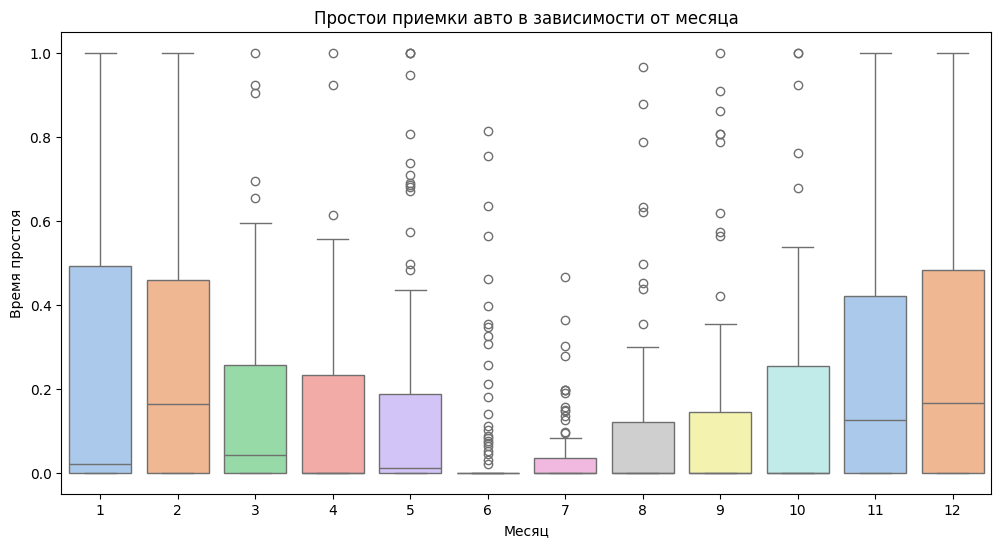

In [82]:
fig = plt.figure(figsize=(12, 6))
# Коробчатая диаграмма
ax = sns.boxplot(final_data, x='month', y='part_day', hue='month', palette='pastel', legend=False)
ax.set_title('Простои приемки авто в зависимости от месяца');
ax.set_xlabel('Месяц');
ax.set_ylabel('Время простоя');

Длительные простои в приемке авто наблюдаются в основном в холодный сезон, так как это напрямую зависит от погоды.

Построим коробчатую диаграмму, показывающую заполненность стоянки в зависимости от того, рабочий день или нет.

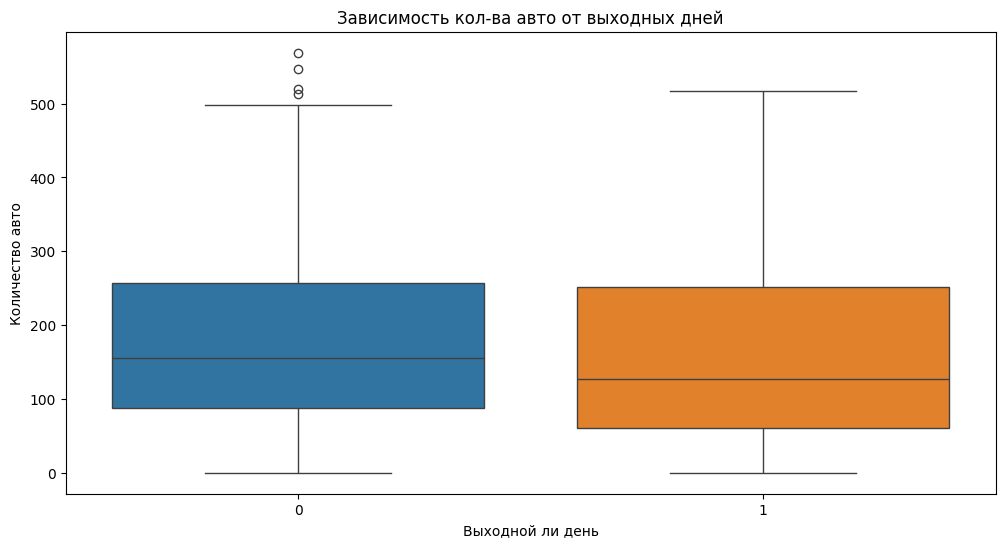

In [83]:
fig = plt.figure(figsize=(12, 6))
# Коробчатая диаграмма
ax = sns.boxplot(final_data, x='is_holiday', y='num_autos', hue='is_holiday', legend=False)
ax.set_title('Зависимость кол-ва авто от выходных дней')
ax.set_xlabel('Выходной ли день')
ax.set_ylabel('Количество авто');

На первый взгляд, разница несущественна, в выходные дни наблюдается меньшая медиана, что можно списать на отсутствие больших пробок в эти дни.

В дальнейшем посмотрим более точное влияние этого признака на целевую переменную.

Сохраним полученный датасет чтобы не прогонять код каждый раз

In [84]:
# final_data.to_csv('data/final_data.csv')

In [85]:
# final_data = pd.read_csv('data/final_data.csv')
# final_data = final_data.iloc[:, 1:]
# final_data.head()

## 3. Масштабирование и отбор признаков

Перед масштабированием разобьем данные на тренировочную и тестовую выборки для того, чтобы избежать утечики данных и только потом применим к ним стандартизацию, остальные временные признаки преобразуем вручную, так как они считаются циклическими.

In [86]:
from sklearn.preprocessing import StandardScaler

X = final_data.drop(['num_autos', 'date'], axis=1)
y = final_data['num_autos']

# Создадим новую переменную, оставив X для пайплайна
X_scaled = X.copy()

# День недели
X_scaled['day_of_week_sin'] = np.sin(2 * np.pi * X['day_of_week'] / 7)
X_scaled['day_of_week_cos'] = np.cos(2 * np.pi * X['day_of_week'] / 7)

# Месяц
X_scaled['month_sin'] = np.sin(2 * np.pi * (X['month'] - 1) / 12)
X_scaled['month_cos'] = np.cos(2 * np.pi * (X['month'] - 1) / 12)

# День
X_scaled['day_sin'] = np.sin(2 * np.pi * (X['day'] - 1) / 31)
X_scaled['day_cos'] = np.cos(2 * np.pi * (X['day'] - 1) / 31)

# Удалим первоначальные признаки
X_scaled.drop(columns=['day_of_week', 'month', 'day'], inplace=True)

# Тренировочная и тестовая выборки в соотношении 80/20
split_index = int(len(X) * 0.8)
X_train_sc, X_test_sc = X_scaled.iloc[:split_index], X_scaled.iloc[split_index:]
y_train_sc, y_test_sc = y.iloc[:split_index], y.iloc[split_index:]

# Сохраним названия колонок
columns = X_scaled.columns

# Столбцы, к которым не применяем стандартизацию
no_scale_cols = [
    'is_holiday',
    'day_sin', 'day_cos',
    'month_sin', 'month_cos',
    'day_of_week_sin', 'day_of_week_cos'
]

# Столбцы для стандартизации
scale_cols = X_scaled.drop(columns=no_scale_cols).columns

# Инициализируем стандартизатор
scaler_std = StandardScaler()

# Применим его на тренировочных и тестовых данных
X_train_sc[scale_cols] = scaler_std.fit_transform(X_train_sc[scale_cols])
X_test_sc[scale_cols] = scaler_std.transform(X_test_sc[scale_cols])

Построим матрицу корреляций на тренировочных данных и узнаем, какие признаки имеют сильную корреляцию

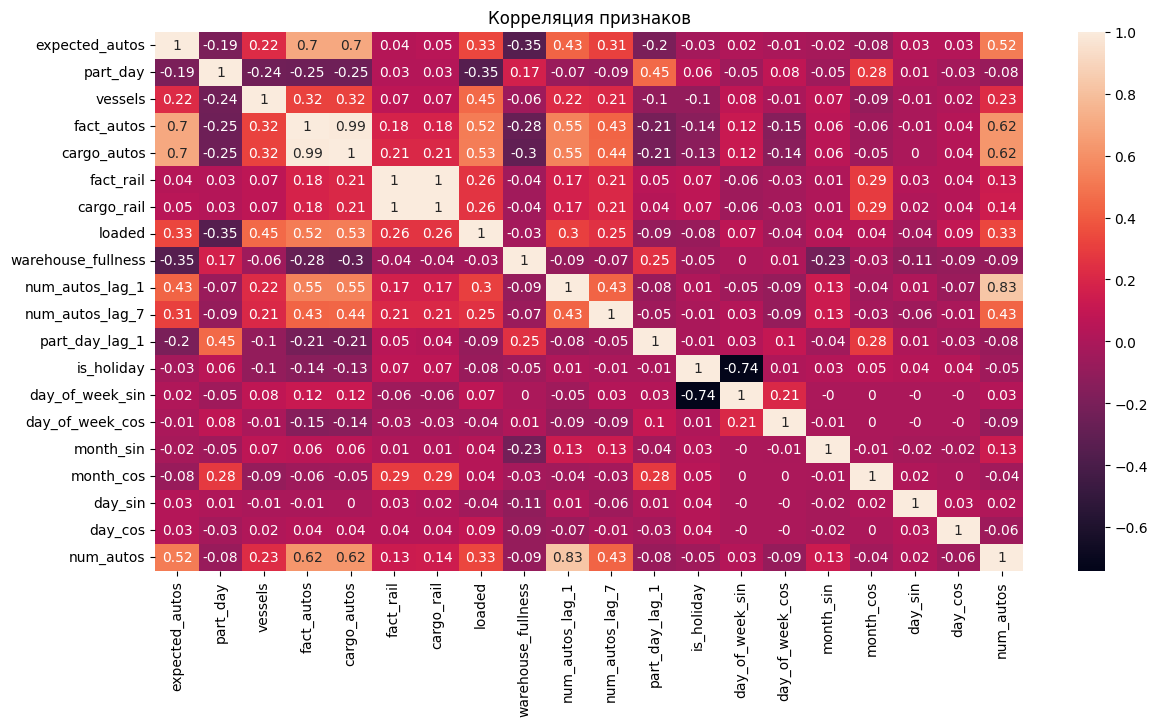

In [87]:
# Соберем датафрейм из тренировочных данных
train_corr = X_train_sc.join(y_train_sc)

# Вычисляем корреляционную матрицу Спирмена
corr_matrix = train_corr.corr(method='spearman', numeric_only=True).round(2)

# Строим тепловую карту корреляций
plt.figure(figsize=(14, 7))
ax = sns.heatmap(corr_matrix, annot=True)
ax.set_title('Корреляция признаков');

В глаза сразу бросаются признаки, полностью дублирующие информацию (`cargo_rail` и `fact_rail`, `cargo_autos` и `fact_autos`), от них необходимо избавиться

In [88]:
X_train_sc.drop(columns=['cargo_autos', 'cargo_rail'], inplace=True)
X_test_sc.drop(columns=['cargo_autos', 'cargo_rail'], inplace=True)

Посмотрим на самые значимые признаки для модели, используя статистический тест ANOVA с функцией `f_regression` для оценки их влияния на целевую переменную.

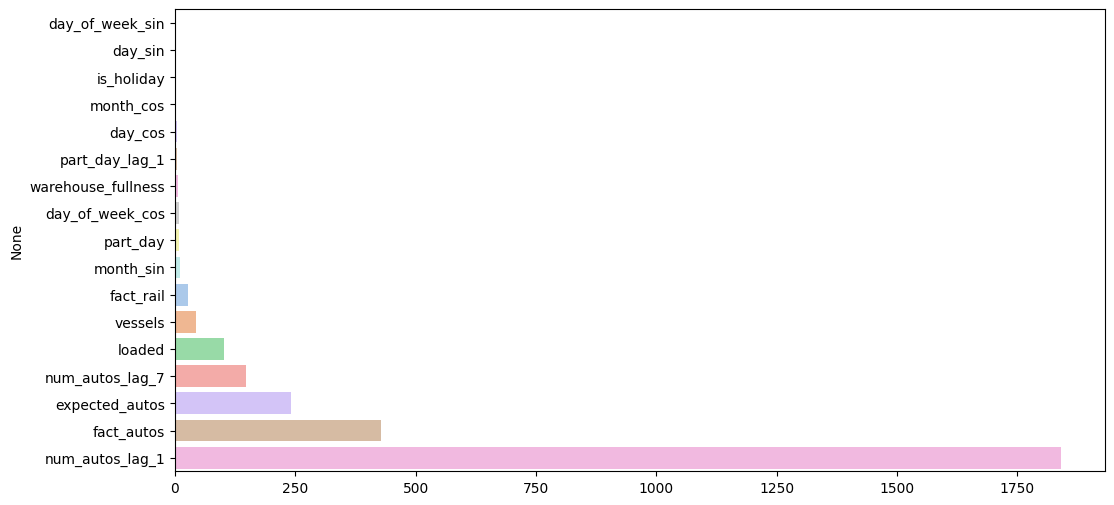

In [89]:
from sklearn.feature_selection import f_regression

# Вернем названия столбцов
cols_X_sc = X_train_sc.columns

# Создадим Series
f_regr = pd.Series(f_regression(X_train_sc, y_train_sc)[0], index=cols_X_sc)
f_regr.sort_values(inplace=True)

# Визуализируем полученные признаки
fig = plt.figure(figsize=(12, 6))
ax = sns.barplot(x=f_regr.values, y=f_regr.index, palette='pastel')

Видно, что ряд признаков практически не имеет линейной зависимости с целевой переменной, однако не стоит спешить их удалять. Будем пробовать модели, которые могут работать с более сложными зависимостями.

## 4. Подбор оптимальной модели

#### 4.1. Обычная линейная регрессия (Baseline)

Построим самую простую модель линейной регрессии и посмотрим на результат.

In [90]:
from sklearn import linear_model, metrics

# Инициализируем модель
model_lr = linear_model.LinearRegression()

# Обучим ее
model_lr.fit(X_train_sc, y_train_sc)

# Сделаем предсказание для тренировочной и тестовой выборок
y_train_pred_lr = model_lr.predict(X_train_sc)
y_test_pred_lr = model_lr.predict(X_test_sc)

# Оценим качество метрики MAE
print('MAE для тренировочной выборки: {:.2f}'.format(metrics.mean_absolute_error(y_train_sc, y_train_pred_lr)))
print('MAE для тестовой выборки: {:.2f}'.format(metrics.mean_absolute_error(y_test_sc, y_test_pred_lr)))

MAE для тренировочной выборки: 47.77
MAE для тестовой выборки: 34.57


Показатель MAE на тестовой выборке оказался ниже, чем на тренировочной. Это означает, что модель слишком простая и не успевает уловить все закономерности  на обучении.

#### 4.2. Линейная регрессия с полиномиальными признаками

In [91]:
from sklearn.preprocessing import PolynomialFeatures

# Полиномиальные признаки 2-ой степени
poly = PolynomialFeatures(degree=2, include_bias=False)

# Применим к нашим данным
X_train_poly = poly.fit_transform(X_train_sc)
X_test_poly = poly.transform(X_test_sc)

# Инициализируем модель
model_lr_poly = linear_model.LinearRegression()

# Обучаем
model_lr_poly.fit(X_train_poly, y_train_sc)

# Предсказание для тренировочной и тестовой выборок
y_train_pred_poly = model_lr_poly.predict(X_train_poly)
y_test_pred_poly = model_lr_poly.predict(X_test_poly)

# Оценим качество
print('MAE для тренировочной выборки: {:.2f}'.format(metrics.mean_absolute_error(y_train_sc, y_train_pred_poly)))
print('MAE для тестовой выборки: {:.2f}'.format(metrics.mean_absolute_error(y_test_sc, y_test_pred_poly)))

MAE для тренировочной выборки: 42.17
MAE для тестовой выборки: 45.51


Добавление полиномиальных признаков 2-ой степени дало небольшое улучшение на обучении, но не привело к заметному снижению ошибки на новых данных.

Попробуем улучшить модель при помощи L2-регуляризации.

#### 4.3. L2-регуляризация на полиномиальных признаках

In [92]:
# Создаем модель с L2-регуляризацией (Ridge)
model_lasso = linear_model.Ridge(alpha=10, max_iter=10000)

# Обучаем модель
model_lasso.fit(X_train_poly, y_train_sc)

# Предсказание
y_train_pred_lasso = model_lasso.predict(X_train_poly)
y_test_pred_lasso = model_lasso.predict(X_test_poly)

# Оценка качества
print('MAE для тренировочной выборки (Ridge): {:.2f}'.format(metrics.mean_absolute_error(y_train_sc, y_train_pred_lasso)))
print('MAE для тестовой выборки (Ridge): {:.2f}'.format(metrics.mean_absolute_error(y_test_sc, y_test_pred_lasso)))

MAE для тренировочной выборки (Ridge): 42.19
MAE для тестовой выборки (Ridge): 43.92


Ошибка на тестовой выборке лишь немного выше, чем на тренировочной. Несмотря на улучшение показателей, результат ещё далёк от идеального.

Перейдем к более сложным моделям


#### 4.4. Случайный лес

Подберем оптимальные гиперпараметры с помощью GridSearchCV.

In [93]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Инициализируем модель случайного леса
model_rf = ensemble.RandomForestRegressor(random_state=42)

# Настраиваем сетку гиперпараметров
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': list(range(2, 8)),
    'min_samples_leaf': list(range(1, 7)),
    'min_samples_split': list(range(1, 7))
}

# Используем TimeSeriesSplit для кросс-валидации с учетом временной структуры данных
tscv = TimeSeriesSplit(n_splits=4)

# Настраиваем GridSearchCV для подбора гиперпараметров
grid_search_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid_rf,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Найдем лучшие гиперпараметры
grid_search_rf.fit(X_train_sc, y_train_sc)

# Выводим лучшие параметры и соответствующую ошибку MAE
print("Лучшие гиперпараметры:", grid_search_rf.best_params_)
print("Лучший CV MAE:", -grid_search_rf.best_score_)

Лучшие гиперпараметры: {'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 300}
Лучший CV MAE: 53.57466495643219


In [94]:
# Получаем лучший обученный RandomForest из GridSearchCV
best_rf = grid_search_rf.best_estimator_

# Предсказания на тестовой и обучающей выборках
y_test_pred_rf = best_rf.predict(X_test_sc)
y_train_pred_rf = best_rf.predict(X_train_sc)

# Оценка качества модели
print('MAE для тренировочной выборки: {:.2f}'.format(metrics.mean_absolute_error(y_train_sc, y_train_pred_rf)))
print('MAE для тестовой выборки: {:.2f}'.format(metrics.mean_absolute_error(y_test_sc, y_test_pred_rf)))

MAE для тренировочной выборки: 34.99
MAE для тестовой выборки: 30.83


После подбора гиперпараметров, случайный лес показал неплохие результаты. Модель стала лучше себя показывать на тренировочных данных имеет даже меньшую ошибку на тесте, что говорит о хорошей обобщающей способности на новых данных.

#### 4.5. Градиентный бустинг (XGBoost)

Для подбора гиперпараметров будем использовать библиотеку Optuna

In [95]:
# import xgboost as xgb
# import optuna

# # Используем TimeSeriesSplit с 4-мя фолдами
# tscv = TimeSeriesSplit(n_splits=4)

# def optuna_xgb(trial):
#     """
#     Функция для подбора гиперпараметров модели XGBoost с использованием Optuna.
#     """
    
#     # Пространство поиска гиперпараметров
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 800),                # Кол-во деревьев
#         'max_depth': trial.suggest_int('max_depth', 3, 10),                         # Глубина дерева
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), # Темп обучения
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),                    # Доля выборки
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),      # Доля признаков
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),           # Мин. вес узла
#         'gamma': trial.suggest_float('gamma', 0, 10),                               # Порог улучшения
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),                        # L1-регуляризация
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),                      # L2-регуляризация
#         'random_state': 42,
#         'tree_method': 'hist',
#     }
    
#     mses = []
    
#     # Кросс-валидация по временным фолдам
#     for train_idx, val_idx in tscv.split(X_train_sc):
#         X_tr, X_val = X_train_sc.iloc[train_idx], X_train_sc.iloc[val_idx]
#         y_tr, y_val = y_train_sc.iloc[train_idx], y_train_sc.iloc[val_idx]
        
#         model = xgb.XGBRegressor(**params)
#         model.fit(X_tr, y_tr, verbose=False)
        
#         preds = model.predict(X_val)
#         mse = metrics.mean_squared_error(y_val, preds)
#         mses.append(mse)
        
#     return np.mean(mses)

# # Создание и запуск Optuna
# study = optuna.create_study(direction='minimize')
# study.optimize(optuna_xgb, n_trials=30, show_progress_bar=True)

Закомментируем эту ячейку кода дабы не прогонять его лишний раз. Выпишем лучшие значения гиперпараметров:

`n_estimators`: 345,

`max_depth`: 4,

`learning_rate`: 0.022,

`subsample`: 0.748,

`colsample_bytree`: 0.943,

`min_child_weight`: 9,

`gamma`: 5.361,

`reg_alpha`: 2.547,

`reg_lambda`: 3.69

In [96]:
import xgboost as xgb

# Инициализируем модель XGBoost
model_xgb = xgb.XGBRegressor(
    n_estimators=345,
    max_depth=4,
    learning_rate=0.022,
    subsample=0.748,
    colsample_bytree=0.943,
    min_child_weight=10,
    gamma=5.361,
    reg_alpha=2.547,
    reg_lambda=3.69
)

# Обучаем ее
model_xgb.fit(X_train_sc, y_train_sc)

# Предсказываем на тренировочной и тестовой выборках
y_pred_train_xgb = model_xgb.predict(X_train_sc)
y_pred_test_xgb = model_xgb.predict(X_test_sc)

print('MAE на тренировочной выборке:', metrics.mean_absolute_error(y_train_sc, y_pred_train_xgb))
print('MAE на тестовой выборке:', metrics.mean_absolute_error(y_test_sc, y_pred_test_xgb))

MAE на тренировочной выборке: 31.280160903930664
MAE на тестовой выборке: 31.597444534301758


Эту модель стоит назвать самой удачной, значения на тренировочной выборке значительно улучшилось и разница между ошибками составляет всего 0.32, что говорит об отсутствии переобучения.

Дополнительно посмотрим на вклад каждого признака в модель и сравним его с предыдущим результатом ANOVA

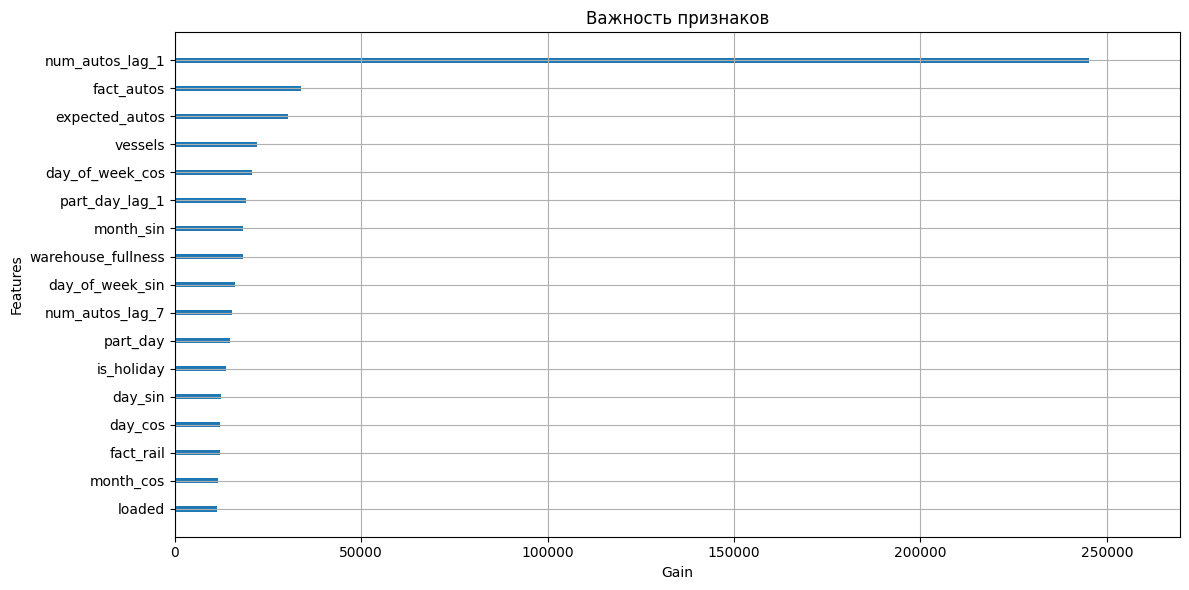

In [97]:
from xgboost import plot_importance

# Создаём фигуру и ось с нужным размером
fig, ax = plt.subplots(figsize=(12, 6))

# Передаём ось явно в plot_importance
plot_importance(model_xgb, importance_type='gain', show_values=False, xlabel='Gain', ax=ax)
plt.title("Важность признаков")
plt.tight_layout()
plt.show()

Стоит обратить внимание, какждый признак внес относительно значимый вклад в целевую переменную. Если бы мы опирались на прошлый график, то часть одних из самых важных признаков
была бы удалена.

#### 4.5.1. Визуализация результатов XGBoost

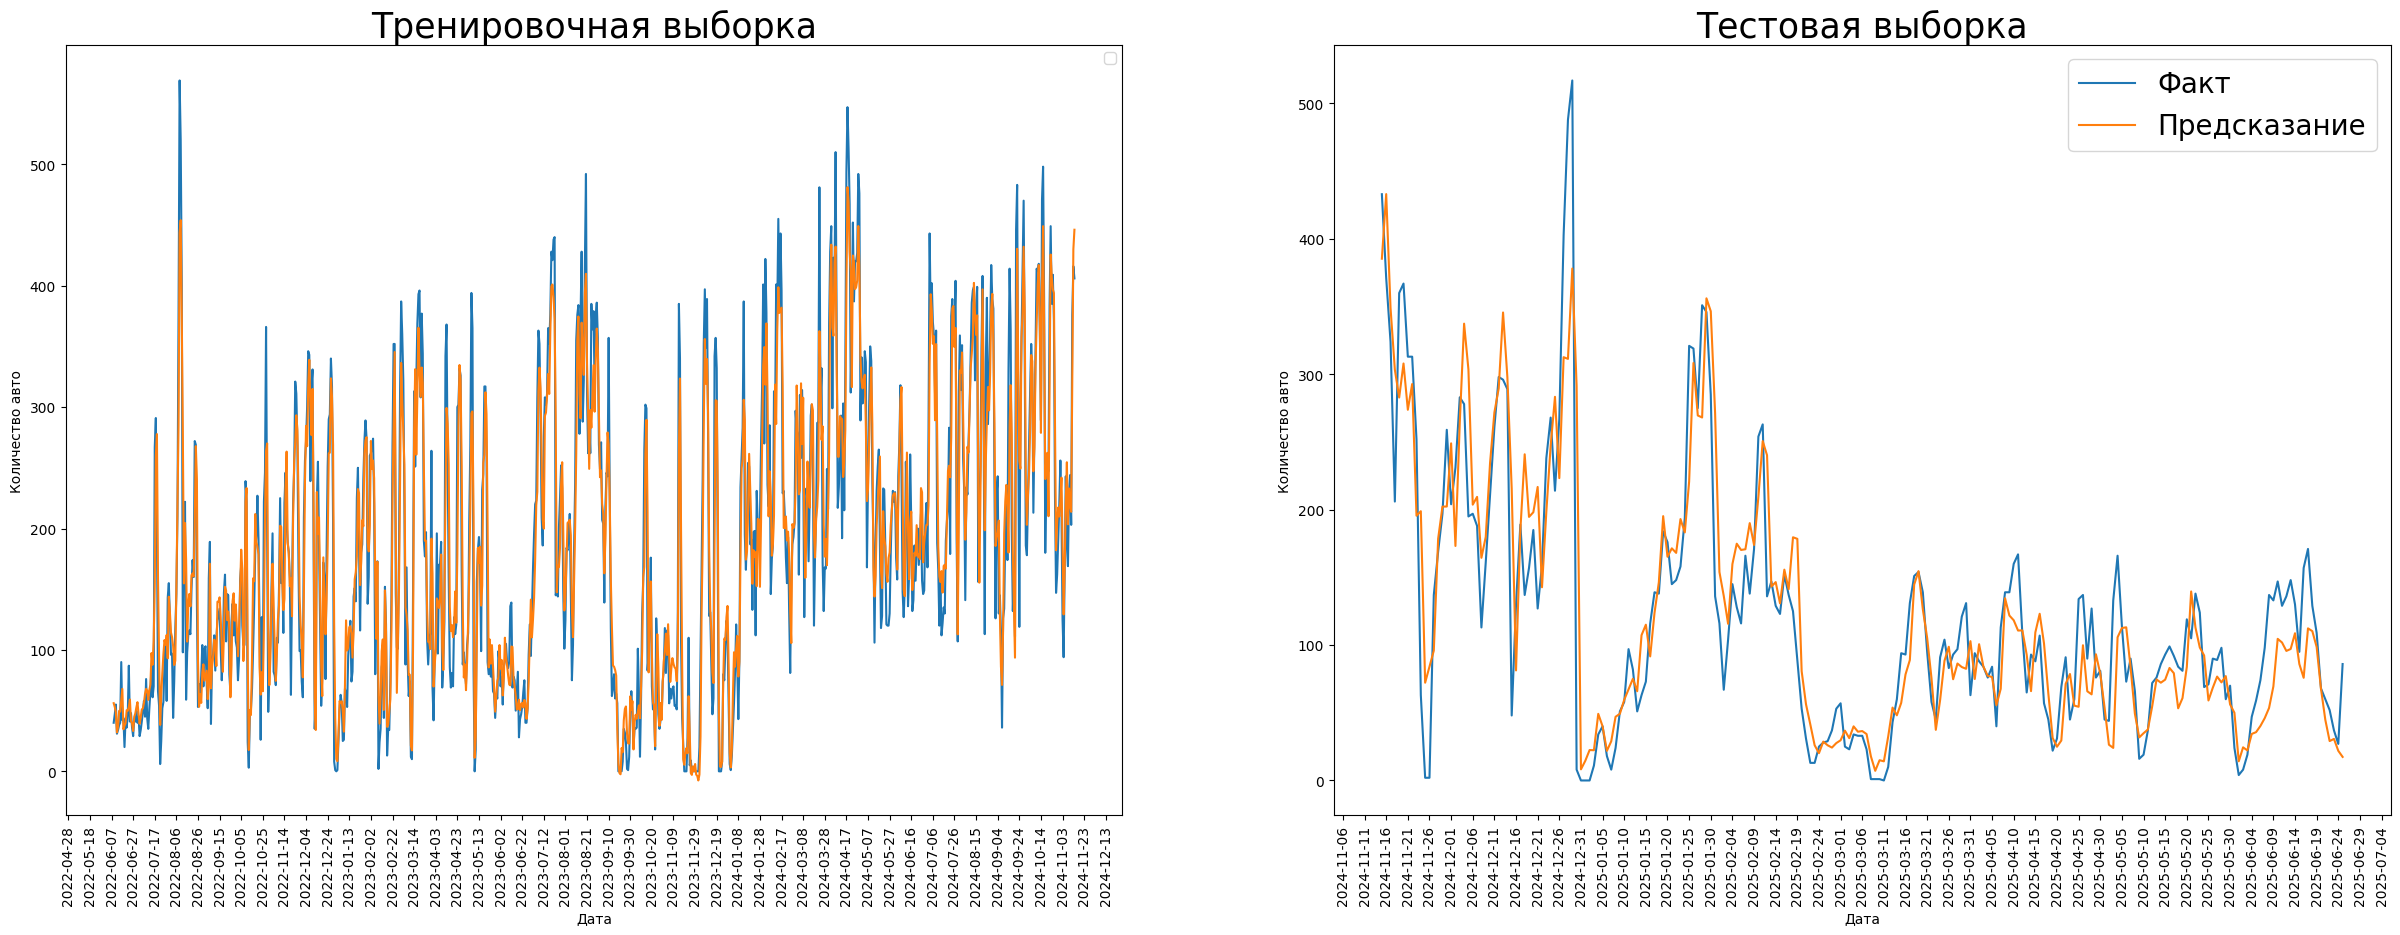

In [98]:
# Соберем индексы дат для визуализации
idx_dates = final_data['date']

# Тренировочные результаты
train_results = pd.DataFrame({
    'true': y_train_sc,
    'pred': y_pred_train_xgb
}).join(idx_dates)

# Тестовые результаты
test_results = pd.DataFrame({
    'true': y_test_sc,
    'pred': y_pred_test_xgb
}).join(idx_dates)

fig, axes = plt.subplots(1, 2, figsize=(30, 10))
# Тренировочные
sns.lineplot(train_results, x='date', y='true', ax=axes[0])
sns.lineplot(train_results, x='date', y='pred', ax=axes[0])
axes[0].set_title('Тренировочная выборка', fontsize=25)
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Количество авто')
axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=20))
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend()
# Тестовые
sns.lineplot(test_results, x='date', y='true', label='Факт', ax=axes[1])
sns.lineplot(test_results, x='date', y='pred', label='Предсказание', ax=axes[1])
axes[1].set_title('Тестовая выборка', fontsize=25)
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество авто')
axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=5))
axes[1].tick_params(axis='x', rotation=90) 
axes[1].legend(fontsize=20);

Результаты на тренировочной выборке в целом хорошо соответствуют реальным значениям, отражая сезонные колебания и периоды повышенной загрузки.

На тестовой выборке модель также демонстрирует удовлетворительное качество — общее направление и динамика предсказаний соответствуют фактическим данным.

Однако стоит отметить, что модель не всегда точно воспроизводит пиковые значения, что может быть связано с ограниченной представленностью таких всплесков в обучающих данных.

## 5. Финальный пайплайн

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin  # базовые классы для трансформеров
from sklearn.compose import ColumnTransformer # комбинированный трансформер столбцов
import joblib

class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """
    Трансформер для создания циклических признаков:
    преобразует столбцы даты в синусоиды и косинусоиды
    """
    def __init__(self, cols, periods):
        self.cols = cols
        self.periods = periods
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.cols:
            p = self.periods[col]
            # Для day_of_week значения 0–6, смещение не требуется
            if col == 'day_of_week':
                X[f"{col}_sin"] = np.sin(2 * np.pi * X[col] / p)
                X[f"{col}_cos"] = np.cos(2 * np.pi * X[col] / p)
            else:
                # Для day и month преобразуем диапазон
                X[f'{col}_sin'] = np.sin(2 * np.pi * (X[col] - 1) / p)
                X[f'{col}_cos'] = np.cos(2 * np.pi * (X[col] - 1) / p)
        return X.drop(columns=self.cols)
    
# Удаляем из X ненужные для пайплайна столбцы
X = X.drop(columns=['cargo_autos', 'cargo_rail'])

# Определяем циклические признаки и их периоды
cyclical_cols = ['day', 'month', 'day_of_week']
periods = {'day': 31, 'month': 12, 'day_of_week': 7}
# Определяем столбцы, которые не будем масштабировать
no_scale_cols = ['is_holiday']

# Все остальные подлежат стандартизации
scale_cols = [col for col in X.columns if col not in cyclical_cols + no_scale_cols]

# Создаем предобработчик
preprocessor = ColumnTransformer(
    transformers=[
        ('cycle', CyclicalFeatures(cyclical_cols, periods), cyclical_cols), # циклические фичи
        ('scale', StandardScaler(), scale_cols) # стандартизация
    ],
    remainder='passthrough' # оставляем остальные без изменений
)

# Собираем пайплайн с моделью XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model_xgb', model_xgb)
])

# Обучение модели на всех данных
pipeline.fit(X, y)

# Сохраняем пайплайн
joblib.dump(pipeline, 'models/xgb_prod_pipeline_v1.joblib')

## Вывод

В ходе работы были собраны необходимые данные с предприятий (операции на зерновом терминале, квоты, простои, суда, информация по всем машинам, заполненность силосов), созданы необходимые для обучения признаки, собран и объединен полноценный датасет. Далее выполнён углублённый анализ: рассчитаны корреляции (Spearman), исследованы распределения и зависимости, визуализированы ключевые признаки и их лаги.

После предварительной подготовки данных были построены следующие модели:

- **Линейная регрессия** (*MAE train* ≈ 48, *MAE test* ≈ 35)
- **Полиномиальная регрессия** (*MAE train* ≈ 42, *MAE test* ≈ 46)
- **Полиномиальная регрессия с L2-регуляризацией Ridge** (*MAE train* ≈ 42, *MAE test* ≈ 44)
- **Случайный лес** (*MAE train* ≈ 35 *MAE test* ≈ 31)

И, наконец, **XGBoost**, оптимизация гиперпараметров которой позволила снизить *MAE* до ≈ 31 на *train* и *test*. Данная модель стабильно воспроизводит общую динамику, хотя пиковые всплески занижает.

Для обеспечения воспроизводимости и удобства дальнейшего использования был собран **Pipeline**, включающий все этапы предобработки и саму модель **XGBoost** с настроенными гиперпараметрами.